# 🏥 Pneumonia Detection from Chest X-Rays Using Deep Learning
### 🌟 Introduction and Why This Project
### Welcome to this deep learning project where we tackle the critical task of detecting pneumonia from chest X-rays. 🚀 This project is not just about applying advanced machine learning techniques; it's about saving lives by aiding quicker and more accurate diagnoses. With pneumonia being a leading cause of death in several age groups, timely and accurate detection can significantly impact patient outcomes. Using the power of TensorFlow and deep learning, we aim to demonstrate how AI can transform medical diagnostics.
## ----------
## Author: Sai Bhaskar Kumpatla

# 🔍 Overview
## This repository contains a comprehensive Jupyter notebook where we build and compare two types of models:

Custom Convolutional Neural Network (CNN): Tailored to fit the specific nuances of our image data.
Transfer Learning with ResNet50: Leveraging pre-trained models to enhance our prediction capabilities.
Through this project, we explore the capabilities of neural networks in interpreting medical imagery, aiming to bridge the gap between data science and medical practic

In [ ]:
!unzip drive/MyDrive/gdrive_pne

In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import random
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# get paths for train, test and validation dataset
main_path = "gdrive_pne/chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

# 📊 Dataset Preprocessing and Visualization
## The dataset consists of chest X-ray images classified into two categories: Normal and Pneumonia. We've meticulously preprocessed this data for optimal neural network performance, which includes:

## Resizing images to uniform dimensions.
## Normalizing pixel values.
## Augmenting the dataset to increase model robustness against overfitting.
## We also perform extensive data visualization to ensure a thorough understanding of the dataset's characteristics, which helps in crafting better machine learning models.

In [ ]:
# Creating DataFrames for Train, Validation, and Test Sets
# Extract file paths for Normal and Pneumonia samples in the training set

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

train_df = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
train_df['image'] = [x for x in train_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

val_df = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
val_df['image'] = [x for x in val_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]


In [ ]:
IMG_SIZE = 224
BATCH = 32

Train Set - Normal


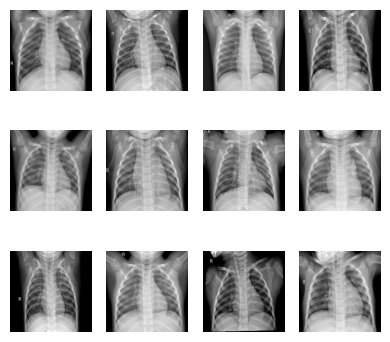

In [ ]:
print('Train Set - Normal')

plt.figure(figsize=(4,4))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


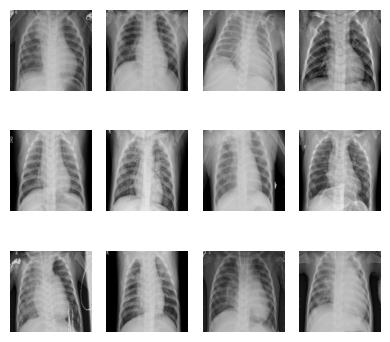

In [ ]:
print('Train Set - Pneumonia')

plt.figure(figsize=(4,4))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [ ]:

class_counts = train_df['class'].value_counts()
min_samples = class_counts.min()
# Create balanced subsets by randomly sampling 'min_samples' samples from each class
normal_subset = train_df[train_df['class'] == 'Normal'].sample(n=min_samples, random_state=42)
pneumonia_subset = train_df[train_df['class'] == 'Pneumonia'].sample(n=min_samples, random_state=42)
balanced_df = pd.concat([normal_subset, pneumonia_subset])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print('Handling Imbalanced Data')
print(class_counts)
print('xxxxxxxxxxx')
print(balanced_df['class'].value_counts())
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

# Imbalanced data was generating better results than the balanced data, hence no changes was made to the training data

Handling Imbalanced Data
Pneumonia    3875
Normal       1341
Name: class, dtype: int64
xxxxxxxxxxx
Normal       1341
Pneumonia    1341
Name: class, dtype: int64


In [ ]:
# Configuration for training data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

#just rescaling and no zoom manipulation. used for both validation and test sets
val_datagen = ImageDataGenerator(rescale=1/255.)

# Creating data generators for training, validation, and testing
ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH
                                             )

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH
                                            )

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)


Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',            # Monitors validation loss for early stopping
    patience=5,                     # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,                 # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True,      # Restores model weights from the epoch with the best value of the monitored quantity
)


## 🛠 Model Training: CNN and Transfer Learning
## Custom CNN Architecture:

We start from scratch, building a CNN that learns from the ground up to identify patterns indicative of pneumonia.
Transfer Learning using ResNet50:

By adapting a model pre-trained on ImageNet, we significantly shorten training time and improve model accuracy, demonstrating the power of transfer learning in medical image analysis.
Both models are rigorously trained and validated, with checkpoints and learning rate adjustments to enhance learning efficacy.

In [ ]:
# Baseline Model Architecture

def get_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # First convolutional block
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Second convolutional block
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer with a single unit and sigmoid activation for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
# Clearing the Keras session to release any resources and avoid potential conflicts with previous models or sessions
keras.backend.clear_session()

# Compiling the model with binary cross-entropy loss and Adam optimizer with a specific learning rate
# The model will track binary accuracy as a metric during training
model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-05), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [ ]:
# Using the 'fit' method to train the model on the training set ('ds_train')
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 20,
          validation_data=ds_val,
          callbacks=[early_stopping]);

Epoch 1/20
163/163 [==============================] - 137s 781ms/step - loss: 0.4317 - binary_accuracy: 0.8087 - val_loss: 1.5459 - val_binary_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - 117s 719ms/step - loss: 0.2695 - binary_accuracy: 0.8878 - val_loss: 2.5358 - val_binary_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - 116s 713ms/step - loss: 0.2285 - binary_accuracy: 0.9074 - val_loss: 2.2633 - val_binary_accuracy: 0.5000
Epoch 4/20
163/163 [==============================] - 126s 770ms/step - loss: 0.2029 - binary_accuracy: 0.9216 - val_loss: 0.8500 - val_binary_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 116s 711ms/step - loss: 0.1839 - binary_accuracy: 0.9319 - val_loss: 0.5008 - val_binary_accuracy: 0.7500
Epoch 6/20
163/163 [==============================] - 114s 700ms/step - loss: 0.1827 - binary_accuracy: 0.9331 - val_loss: 0.3011 - val_binary_accuracy: 0.8750
Epoch 7/20
163/163 [====================

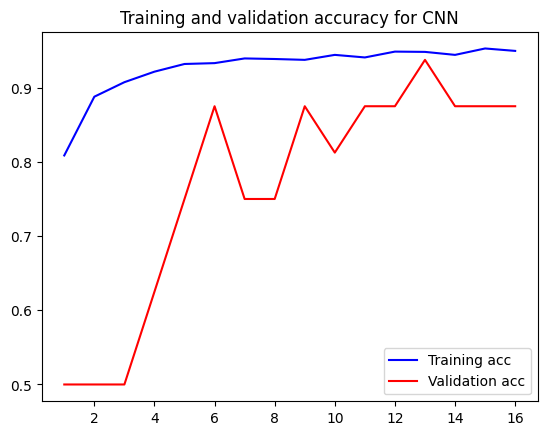

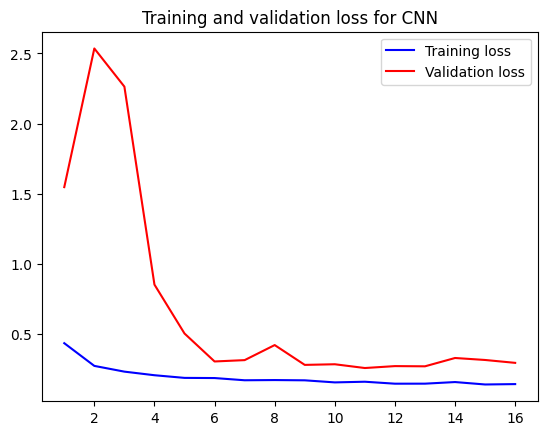

In [ ]:
#getting train and validation accuracies
train_acc_CNN = history.history['binary_accuracy']
val_acc_CNN = history.history['val_binary_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

In [ ]:
# Model Evaluation on Test Set
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

# Using the 'evaluate' method to assess the model's performance on the test set ('ds_test')
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2904219925403595
Test accuracy: 0.8782051205635071


In [ ]:
predictions = model.predict(ds_test, steps=len(df_test), verbose=0)

# Applying a threshold of 0.5 to convert raw predictions to binary labels (0 or 1)
# - Predictions greater than 0.5 are assigned class label 1 (Pneumonia),
# and those less than or equal to 0.5 are assigned class label 0 (Normal)
pred_labels= np.where(predictions>0.5, 1, 0)

In [ ]:
df_test["class"] = df_test["class"].map({"Pneumonia": 1, "Normal": 0})  # Convert to 1 and 0
Y_test = df_test['class']
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))


Test Accuracy:  0.8782051282051282


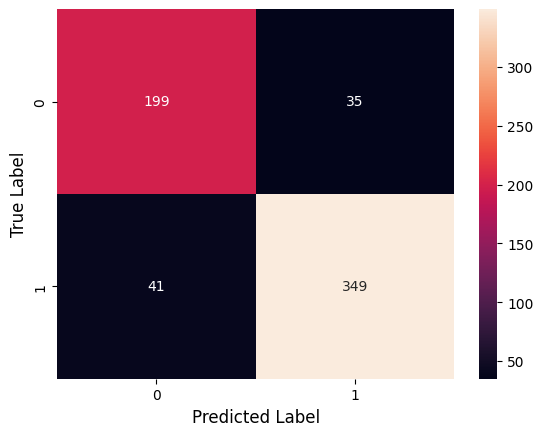

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

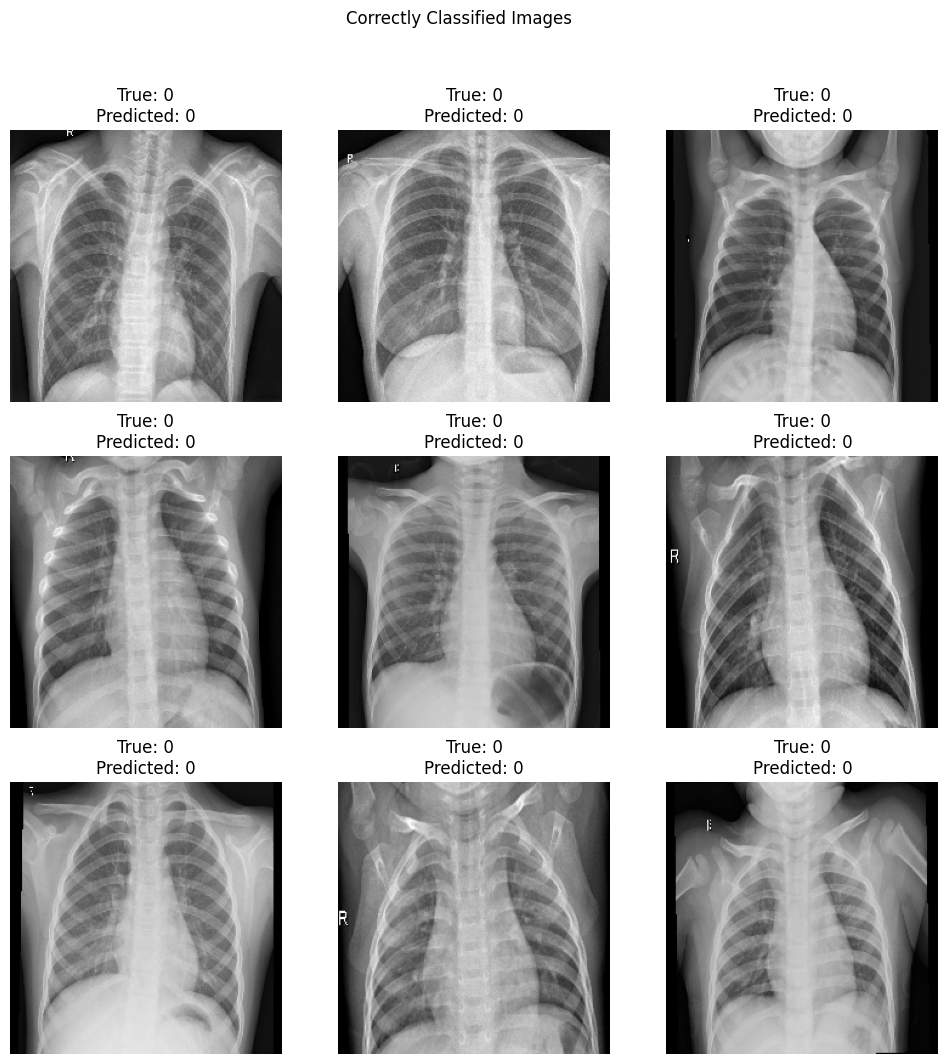

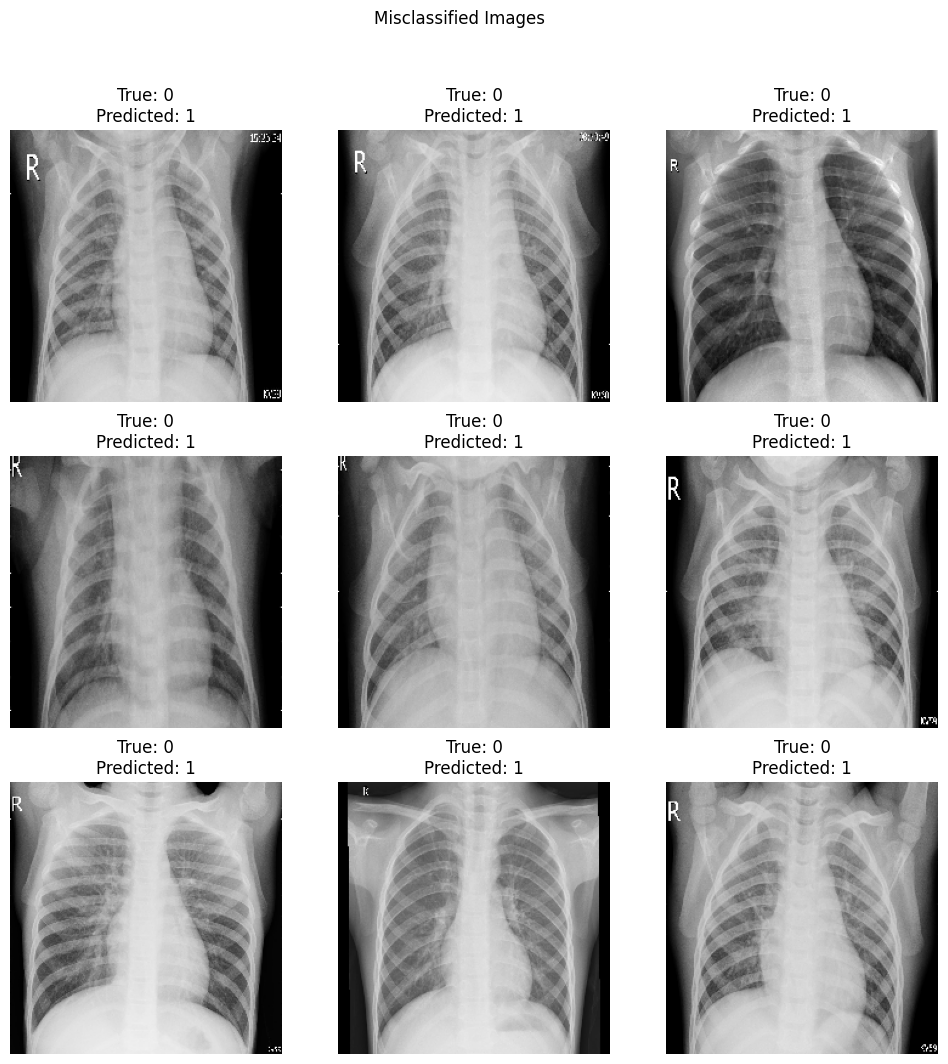

In [ ]:
def display_images(images, true_labels, pred_labels, title):
    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i], axis=0))  # Remove the singleton batch dimension
        plt.title(f'True: {true_labels[i]}\nPredicted: {pred_labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Predict on the test dataset
predictions = model.predict(ds_test, steps=len(df_test), verbose=0)
pred_labels = np.where(predictions > 0.5, 1, 0)

# Get true labels
true_labels = df_test['class']

true_labels = true_labels.values.flatten()
pred_labels = pred_labels.flatten()

# Display correctly classified images
correctly_classified_indices = np.where(pred_labels == true_labels)[0]
correct_images = [ds_test[i][0] for i in correctly_classified_indices[:9]]
correct_labels = true_labels[correctly_classified_indices[:9]]
correct_predictions = pred_labels[correctly_classified_indices[:9]]
display_images(correct_images, correct_labels, correct_predictions, "Correctly Classified Images")

# Display misclassified images
misclassified_indices = np.where(pred_labels != true_labels)[0]
misclassified_images = [ds_test[i][0] for i in misclassified_indices[:9]]
misclassified_labels = true_labels[misclassified_indices[:9]]
misclassified_predictions = pred_labels[misclassified_indices[:9]]
display_images(misclassified_images, misclassified_labels, misclassified_predictions, "Misclassified Images")



# --------------------TRANSFER LEARNING----------------

In [ ]:
# Pre-trained ResNet50 Model Creation

# Using the ResNet50 model pre-trained on ImageNet as the base model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

# Freezing the weights of the pre-trained layers to prevent them from being updated during training
base_model.trainable = False

def get_pretrained():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
keras.backend.clear_session()

# Creating and compiling the pre-trained model using the 'get_pretrained' function
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=1e-04), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history_pretrained = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 20,
          validation_data=ds_val);

Epoch 1/20
163/163 [==============================] - 124s 731ms/step - loss: 0.5726 - binary_accuracy: 0.7421 - val_loss: 0.8129 - val_binary_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - 115s 704ms/step - loss: 0.5481 - binary_accuracy: 0.7437 - val_loss: 0.7620 - val_binary_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - 116s 710ms/step - loss: 0.5210 - binary_accuracy: 0.7431 - val_loss: 0.7201 - val_binary_accuracy: 0.5000
Epoch 4/20
163/163 [==============================] - 116s 713ms/step - loss: 0.5003 - binary_accuracy: 0.7442 - val_loss: 0.8335 - val_binary_accuracy: 0.5000
Epoch 5/20
163/163 [==============================] - 114s 697ms/step - loss: 0.4820 - binary_accuracy: 0.7546 - val_loss: 0.7833 - val_binary_accuracy: 0.5000
Epoch 6/20
163/163 [==============================] - 115s 706ms/step - loss: 0.4669 - binary_accuracy: 0.7556 - val_loss: 0.7493 - val_binary_accuracy: 0.5625
Epoch 7/20
163/163 [====================

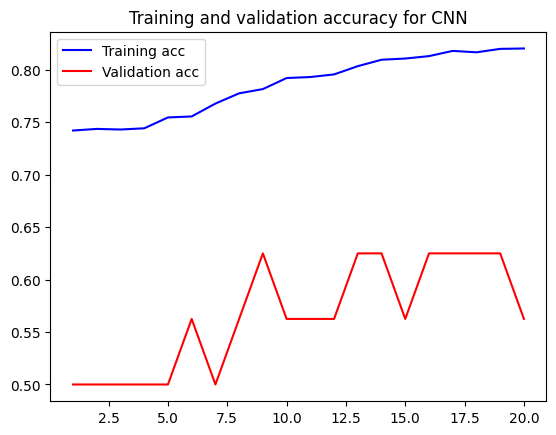

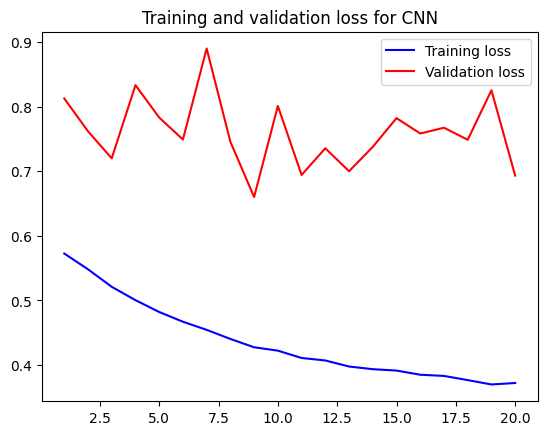

In [ ]:
#getting train and validation accuracies
train_acc_CNN = history_pretrained.history['binary_accuracy']
val_acc_CNN = history_pretrained.history['val_binary_accuracy']

#getting train and validation losses
train_loss_CNN = history_pretrained.history['loss']
val_loss_CNN = history_pretrained.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

In [ ]:
# Model Evaluation on Test Set
# We can see that there is quite a difference between the validation accuracy and the test accuracy, but note that train accuracy at the top is ~80%
# which means that clear the model has not been trained for sufficient amount of epochs but overfitting was not the case as we can see that difference between train accuracy and test accuracy is not too much
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
predictions = model_pretrained.predict(ds_test, steps=len(df_test), verbose=0)

# Applying a threshold of 0.5 to convert raw predictions to binary labels (0 or 1)
# - Predictions greater than 0.5 are assigned class label 1 (Pneumonia),
# and those less than or equal to 0.5 are assigned class label 0 (Normal)
pred_labels= np.where(predictions>0.5, 1, 0)

In [ ]:
df_test["class"] = df_test["class"].map({"Pneumonia": 1, "Normal": 0})  # Convert to 1 and 0
Y_test = df_test['class']
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))


Test Accuracy:  0.7708333333333334


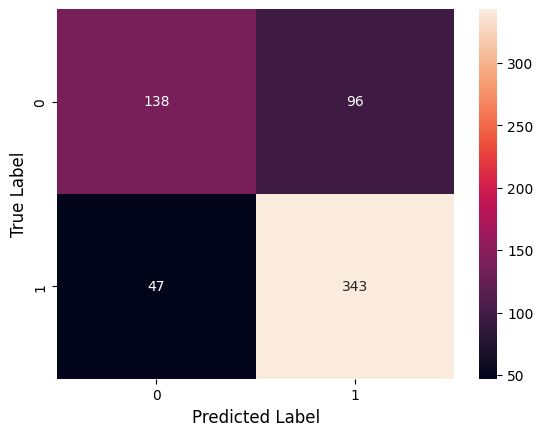

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66       234
           1       0.78      0.88      0.83       390

    accuracy                           0.77       624
   macro avg       0.76      0.73      0.74       624
weighted avg       0.77      0.77      0.76       624



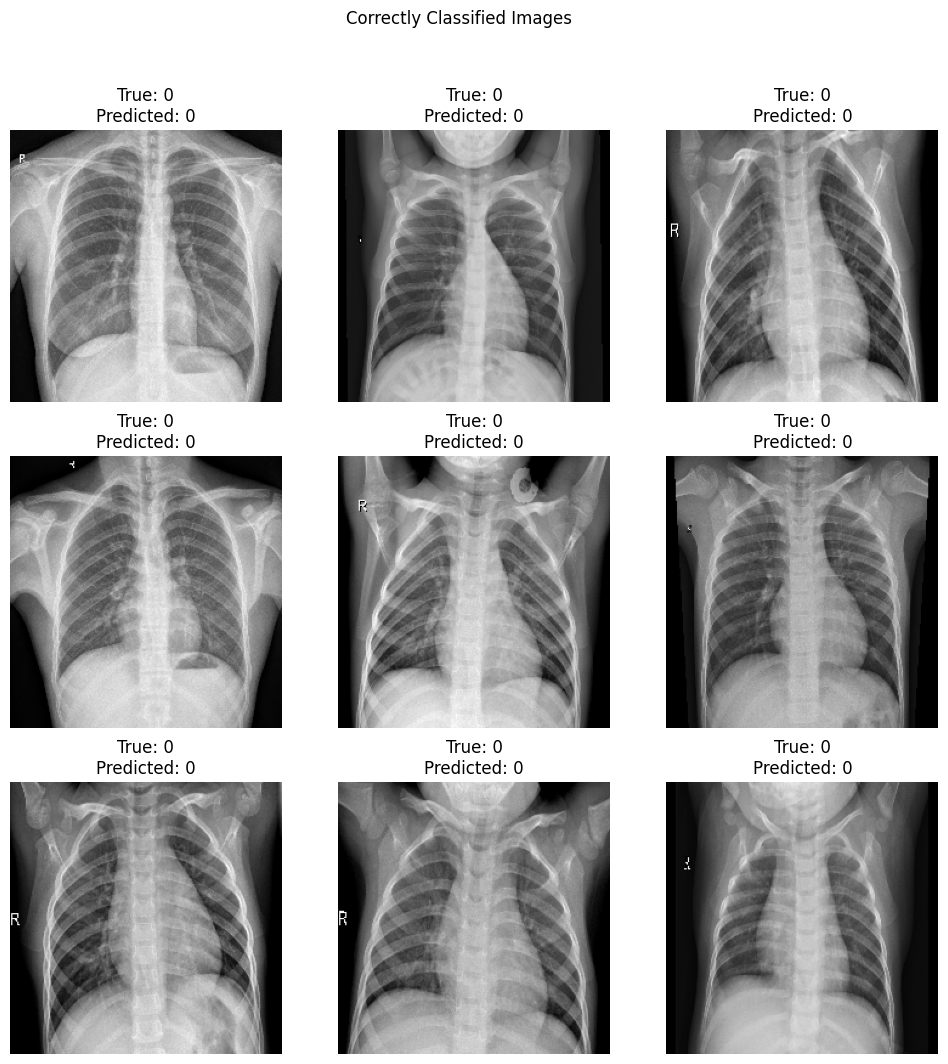

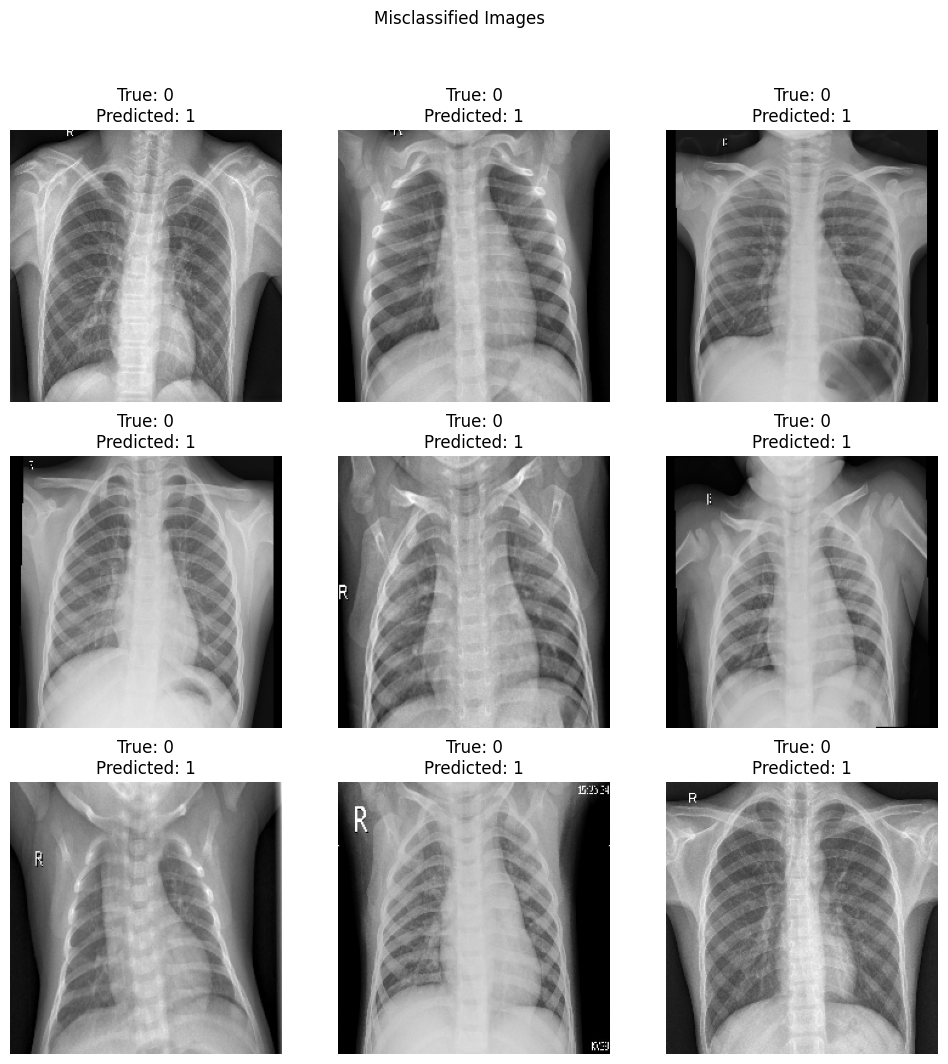

In [ ]:

# Predict on the test dataset
predictions = model_pretrained.predict(ds_test, steps=len(df_test), verbose=0)
pred_labels = np.where(predictions > 0.5, 1, 0)

# Get true labels
true_labels = df_test['class']

true_labels = true_labels.values.flatten()
pred_labels = pred_labels.flatten()

# Display correctly classified images
correctly_classified_indices = np.where(pred_labels == true_labels)[0]
correct_images = [ds_test[i][0] for i in correctly_classified_indices[:9]]
correct_labels = true_labels[correctly_classified_indices[:9]]
correct_predictions = pred_labels[correctly_classified_indices[:9]]
display_images(correct_images, correct_labels, correct_predictions, "Correctly Classified Images")

# Display misclassified images
misclassified_indices = np.where(pred_labels != true_labels)[0]
misclassified_images = [ds_test[i][0] for i in misclassified_indices[:9]]
misclassified_labels = true_labels[misclassified_indices[:9]]
misclassified_predictions = pred_labels[misclassified_indices[:9]]
display_images(misclassified_images, misclassified_labels, misclassified_predictions, "Misclassified Images")



# 📈 Conclusion
## This project showcases the potent combination of neural networks and medical imaging, bringing out the best of AI in healthcare. The models developed here could potentially serve as a preliminary diagnosis tool, assisting radiologists in identifying pneumonia from X-rays with higher accuracy and speed.

## Note: This project is for educational purposes and should be used as a supplementary tool in clinical settings.